<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/02_backtesting_risk_management/W5_backtrader_%26_bt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practicing Backtesting Libraries

## Backtrader

### Replicating Quickstart to Learn

#### Importing Libraries

In [1]:
!pip install backtrader

In [2]:
#importing the library with alias bt
import backtrader as bt
#importing otehr libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os.path
import sys

#### Basic SetUp

In [3]:
#initiating the Cerebro class
cerebro = bt.Cerebro()
#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

Starting Value: 500000.00
Final Value: 500000.00


#### Adding Data

In [4]:
#initiating the Cerebro class
cerebro = bt.Cerebro()

#getting data via yf API
data = yf.download('SPY',start='2015-01-01',end='2025-01-01')
#remove the multi-ndexing of the dataframe
data = data.droplevel(level=1,axis=1)
#load into backtrader the pd.dataframe
data = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data)


#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Starting Value: 500000.00
Final Value: 500000.00


#### Adding a Strategy

In [5]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')
        #if closing prices are decresing two consecutive days -> buy
        if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
          self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
          self.buy()

#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

#getting data via yf API
data = yf.download('SPY',start='2022-01-01',end='2025-01-01')
#remove the multi-ndexing of the dataframe
data = data.droplevel(level=1,axis=1)
#load into backtrader the pd.dataframe
data = bt.feeds.PandasData(dataname=data)

#add data to cerebro
cerebro.adddata(data)


#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

[*********************100%***********************]  1 of 1 completed


Starting Value: 500000.00
2022-01-03 Close Price, 455.81
2022-01-03 BUY CREATED 455.81
2022-01-04 Close Price, 455.66
2022-01-04 BUY CREATED 455.66
2022-01-05 Close Price, 446.91
2022-01-05 BUY CREATED 446.91
2022-01-06 Close Price, 446.49
2022-01-06 BUY CREATED 446.49
2022-01-07 Close Price, 444.72
2022-01-07 BUY CREATED 444.72
2022-01-10 Close Price, 444.17
2022-01-10 BUY CREATED 444.17
2022-01-11 Close Price, 448.22
2022-01-12 Close Price, 449.43
2022-01-13 Close Price, 443.23
2022-01-14 Close Price, 443.42
2022-01-18 Close Price, 435.56
2022-01-19 Close Price, 431.04
2022-01-19 BUY CREATED 431.04
2022-01-20 Close Price, 426.27
2022-01-20 BUY CREATED 426.27
2022-01-21 Close Price, 417.9
2022-01-21 BUY CREATED 417.9
2022-01-24 Close Price, 419.68
2022-01-25 Close Price, 414.55
2022-01-26 Close Price, 413.51
2022-01-26 BUY CREATED 413.51
2022-01-27 Close Price, 411.47
2022-01-27 BUY CREATED 411.47
2022-01-28 Close Price, 421.69
2022-01-31 Close Price, 429.28
2022-02-01 Close Price, 43

In [6]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # to keep track of orders
        self.order = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {round(order.executed.price,2)}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {round(order.executed.price,2)}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Set no order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')

        #check if an order is pending... if true do not send a 2nd order
        if self.order:
            return
        #check if we are in the marker
        if not self.position:
            #we might buy if
            if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
              self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
              self.order = self.buy()
        else:
          #if already in the market we might sell if:
          if len(self) >= (self.bar_executed + 5):
            self.log(f'SELL CREATED {round(self.dataclose[0],2)}')
            self.order = self.sell()



#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

#getting data via yf API
data = yf.download('SPY',start='2022-01-01',end='2025-01-01')
#remove the multi-ndexing of the dataframe
data = data.droplevel(level=1,axis=1)
#load into backtrader the pd.dataframe
data = bt.feeds.PandasData(dataname=data)

#add data to cerebro
cerebro.adddata(data)


#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

[*********************100%***********************]  1 of 1 completed


Starting Value: 500000.00
2022-01-03 Close Price, 455.81
2022-01-03 BUY CREATED 455.81
2022-01-04 BUY EXECUTED, 457.25
2022-01-04 Close Price, 455.66
2022-01-05 Close Price, 446.91
2022-01-06 Close Price, 446.49
2022-01-07 Close Price, 444.72
2022-01-10 Close Price, 444.17
2022-01-11 Close Price, 448.22
2022-01-11 SELL CREATED 448.22
2022-01-12 SELL EXECUTED, 449.97
2022-01-12 Close Price, 449.43
2022-01-13 Close Price, 443.23
2022-01-14 Close Price, 443.42
2022-01-18 Close Price, 435.56
2022-01-19 Close Price, 431.04
2022-01-19 BUY CREATED 431.04
2022-01-20 BUY EXECUTED, 432.95
2022-01-20 Close Price, 426.27
2022-01-21 Close Price, 417.9
2022-01-24 Close Price, 419.68
2022-01-25 Close Price, 414.55
2022-01-26 Close Price, 413.51
2022-01-27 Close Price, 411.47
2022-01-27 SELL CREATED 411.47
2022-01-28 SELL EXECUTED, 412.84
2022-01-28 Close Price, 421.69
2022-01-31 Close Price, 429.28
2022-02-01 Close Price, 432.19
2022-02-02 Close Price, 436.38
2022-02-03 Close Price, 426.13
2022-02-04

#### Adding Commissions

In [7]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # to keep track of orders
        self.order = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Set no order
        self.order = None

    def notify_trade(self,trade):
      if not trade.isclosed:
        return
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')

        #check if an order is pending... if true do not send a 2nd order
        if self.order:
            return
        #check if we are in the marker
        if not self.position:
            #we might buy if
            if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
              self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
              self.order = self.buy()
        else:
          #if already in the market we might sell if:
          if len(self) >= (self.bar_executed + 5):
            self.log(f'SELL CREATED {round(self.dataclose[0],2)}')
            self.order = self.sell()



#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

#getting data via yf API
data = yf.download('SPY',start='2022-01-01',end='2025-01-01')
#remove the multi-ndexing of the dataframe
data = data.droplevel(level=1,axis=1)
#load into backtrader the pd.dataframe
data = bt.feeds.PandasData(dataname=data)

#add data to cerebro
cerebro.adddata(data)

#adding 0.1% commission
cerebro.broker.setcommission(commission=0.001)


#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

[*********************100%***********************]  1 of 1 completed

Starting Value: 500000.00
2022-01-03 Close Price, 455.81
2022-01-03 BUY CREATED 455.81
2022-01-04 BUY EXECUTED, Price: 457.25, Cost: 457.25, Comm: 0.46
2022-01-04 Close Price, 455.66
2022-01-05 Close Price, 446.91
2022-01-06 Close Price, 446.49
2022-01-07 Close Price, 444.72
2022-01-10 Close Price, 444.17
2022-01-11 Close Price, 448.22
2022-01-11 SELL CREATED 448.22
2022-01-12 SELL EXECUTED, Price: 449.97, Cost: 457.25, Comm: 0.45
2022-01-12 OPERATION PROFIT, GROSS -7.28, NET -8.19
2022-01-12 Close Price, 449.43
2022-01-13 Close Price, 443.23
2022-01-14 Close Price, 443.42
2022-01-18 Close Price, 435.56
2022-01-19 Close Price, 431.04
2022-01-19 BUY CREATED 431.04
2022-01-20 BUY EXECUTED, Price: 432.95, Cost: 432.95, Comm: 0.43
2022-01-20 Close Price, 426.27
2022-01-21 Close Price, 417.9
2022-01-24 Close Price, 419.68
2022-01-25 Close Price, 414.55
2022-01-26 Close Price, 413.51
2022-01-27 Close Price, 411.47
2022-01-27 SELL CREATED 411.47
2022-01-28 SELL EXECUTED, Price: 412.84, Cost: 

2022-03-21 Close Price, 425.34
2022-03-22 Close Price, 430.31
2022-03-23 Close Price, 424.77
2022-03-24 Close Price, 431.17
2022-03-25 Close Price, 433.28
2022-03-28 Close Price, 436.36
2022-03-29 Close Price, 441.76
2022-03-30 Close Price, 439.03
2022-03-31 Close Price, 432.27
2022-03-31 BUY CREATED 432.27
2022-04-01 BUY EXECUTED, Price: 433.87, Cost: 433.87, Comm: 0.43
2022-04-01 Close Price, 433.5
2022-04-04 Close Price, 437.21
2022-04-05 Close Price, 431.69
2022-04-06 Close Price, 427.37
2022-04-07 Close Price, 429.53
2022-04-08 Close Price, 428.38
2022-04-08 SELL CREATED 428.38
2022-04-11 SELL EXECUTED, Price: 425.07, Cost: 433.87, Comm: 0.43
2022-04-11 OPERATION PROFIT, GROSS -8.81, NET -9.66
2022-04-11 Close Price, 421.06
2022-04-11 BUY CREATED 421.06
2022-04-12 BUY EXECUTED, Price: 424.08, Cost: 424.08, Comm: 0.42
2022-04-12 Close Price, 419.5
2022-04-13 Close Price, 424.3
2022-04-14 Close Price, 419.02
2022-04-18 Close Price, 419.19
2022-04-19 Close Price, 425.96
2022-04-20 Cl

#### Adding Parameters

In [8]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):
    params = (('exitbars',6),)

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # to keep track of orders
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Set no order
        self.order = None

    def notify_trade(self,trade):
      if not trade.isclosed:
        return
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')

        #check if an order is pending... if true do not send a 2nd order
        if self.order:
            return
        #check if we are in the marker
        if not self.position:
            #we might buy if
            if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
              self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
              self.order = self.buy()
        else:
          #if already in the market we might sell if:
          if len(self) >= (self.bar_executed + 5):
            self.log(f'SELL CREATED {round(self.dataclose[0],2)}')
            self.order = self.sell()



#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

#getting data via yf API
data = yf.download('SPY',start='2022-01-01',end='2025-01-01')
#remove the multi-ndexing of the dataframe
data = data.droplevel(level=1,axis=1)
#load into backtrader the pd.dataframe
data = bt.feeds.PandasData(dataname=data)

#add data to cerebro
cerebro.adddata(data)

#adding 0.1% commission
cerebro.broker.setcommission(commission=0.001)


#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

[*********************100%***********************]  1 of 1 completed

Starting Value: 500000.00


2022-01-03 Close Price, 455.81
2022-01-03 BUY CREATED 455.81
2022-01-04 BUY EXECUTED, Price: 457.25, Cost: 457.25, Comm: 0.46
2022-01-04 Close Price, 455.66
2022-01-05 Close Price, 446.91
2022-01-06 Close Price, 446.49
2022-01-07 Close Price, 444.72
2022-01-10 Close Price, 444.17
2022-01-11 Close Price, 448.22
2022-01-11 SELL CREATED 448.22
2022-01-12 SELL EXECUTED, Price: 449.97, Cost: 457.25, Comm: 0.45
2022-01-12 OPERATION PROFIT, GROSS -7.28, NET -8.19
2022-01-12 Close Price, 449.43
2022-01-13 Close Price, 443.23
2022-01-14 Close Price, 443.42
2022-01-18 Close Price, 435.56
2022-01-19 Close Price, 431.04
2022-01-19 BUY CREATED 431.04
2022-01-20 BUY EXECUTED, Price: 432.95, Cost: 432.95, Comm: 0.43
2022-01-20 Close Price, 426.27
2022-01-21 Close Price, 417.9
2022-01-24 Close Price, 419.68
2022-01-25 Close Price, 414.55
2022-01-26 Close Price, 413.51
2022-01-27 Close Price, 411.47
2022-01-27 SELL CREATED 411.47
2022-01-28 SELL EXECUTED, Price: 412.84, Cost: 432.95, Comm: 0.41
2022-01

#### Adding an Indicator

- Buy “AtMarket” if the close is greater than the Average

- If in the market, sell if the close is smaller than the Average

- Only 1 active operation is allowed in the market

In [9]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):
    params = (('maperiod',15),)

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # to keep track of orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        #MA indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0],period=self.params.maperiod)

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Set no order
        self.order = None

    def notify_trade(self,trade):
      if not trade.isclosed:
        return
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')

        #check if an order is pending... if true do not send a 2nd order
        if self.order:
            return
        #check if we are in the marker
        if not self.position:
            #we might buy if
            if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
              self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
              self.order = self.buy()
        else:
          #if already in the market we might sell if:
          if len(self) >= (self.bar_executed + 5):
            self.log(f'SELL CREATED {round(self.dataclose[0],2)}')
            self.order = self.sell()



#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

#getting data via yf API
data = yf.download('SPY',start='2022-01-01',end='2025-01-01')
#remove the multi-ndexing of the dataframe
data = data.droplevel(level=1,axis=1)
#load into backtrader the pd.dataframe
data = bt.feeds.PandasData(dataname=data)

#add data to cerebro
cerebro.adddata(data)

#set our desired cash start
cerebro.broker.setcash(1000.0)

#adding 0.1% commission
cerebro.broker.setcommission(commission=0.00)

print(f'Starting Value: {cerebro.broker.getvalue()}')
#run the backtest
cerebro.run()
print(f'Final Value: {round(cerebro.broker.getvalue(),2)}')

[*********************100%***********************]  1 of 1 completed


Starting Value: 1000.0
2022-01-24 Close Price, 419.68
2022-01-25 Close Price, 414.55
2022-01-26 Close Price, 413.51
2022-01-26 BUY CREATED 413.51
2022-01-27 BUY EXECUTED, Price: 418.17, Cost: 418.17, Comm: 0.0
2022-01-27 Close Price, 411.47
2022-01-28 Close Price, 421.69
2022-01-31 Close Price, 429.28
2022-02-01 Close Price, 432.19
2022-02-02 Close Price, 436.38
2022-02-03 Close Price, 426.13
2022-02-03 SELL CREATED 426.13
2022-02-04 SELL EXECUTED, Price: 425.89, Cost: 418.17, Comm: 0.0
2022-02-04 OPERATION PROFIT, GROSS 7.72, NET 7.72
2022-02-04 Close Price, 428.13
2022-02-07 Close Price, 426.76
2022-02-08 Close Price, 430.27
2022-02-09 Close Price, 436.57
2022-02-10 Close Price, 428.72
2022-02-11 Close Price, 420.27
2022-02-11 BUY CREATED 420.27
2022-02-14 BUY EXECUTED, Price: 419.75, Cost: 419.75, Comm: 0.0
2022-02-14 Close Price, 418.89
2022-02-15 Close Price, 425.65
2022-02-16 Close Price, 426.13
2022-02-17 Close Price, 417.02
2022-02-18 Close Price, 414.32
2022-02-22 Close Price,

#### Plotting

Before plotting to make it cooler let's add:
- A 2nd MovingAverage (Exponential) will be added. The defaults will plot it (just like the 1st) with the data.

- A 3rd MovingAverage (Weighted) will be added. Customized to plot in an own plot (even if not sensible)

- A Stochastic (Slow) will be added. No change to the defaults.

- A MACD will be added. No change to the defaults.

- A RSI will be added. No change to the defaults.

- A MovingAverage (Simple) will be applied to the RSI. No change to the defaults (it will be plotted with the RSI)

- An AverageTrueRange will be added. Changed defaults to avoid it being plotted.

In [10]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):
    params = (('maperiod',15),)

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # to keep track of orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        #MA indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0],period=self.params.maperiod)

        #--------OTHER INDICATORS JUST FOR PLOTTING PURPOSES--------#
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Set no order
        self.order = None

    def notify_trade(self,trade):
      if not trade.isclosed:
        return
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')

        #check if an order is pending... if true do not send a 2nd order
        if self.order:
            return
        #check if we are in the marker
        if not self.position:
            #we might buy if
            if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
              self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
              self.order = self.buy()
        else:
          #if already in the market we might sell if:
          if len(self) >= (self.bar_executed + 5):
            self.log(f'SELL CREATED {round(self.dataclose[0],2)}')
            self.order = self.sell()



#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

#getting data via yf API
data = yf.download('SPY',start='2022-01-01',end='2025-01-01')
#remove the multi-ndexing of the dataframe
data = data.droplevel(level=1,axis=1)
#load into backtrader the pd.dataframe
data = bt.feeds.PandasData(dataname=data)

#add data to cerebro
cerebro.adddata(data)

#set our desired cash start
cerebro.broker.setcash(1000.0)

#adding 0.1% commission
cerebro.broker.setcommission(commission=0.00)

print(f'Starting Value: {cerebro.broker.getvalue()}')
#run the backtest
cerebro.run()
print(f'Final Value: {round(cerebro.broker.getvalue(),2)}')


[*********************100%***********************]  1 of 1 completed


Starting Value: 1000.0
2022-02-18 Close Price, 414.32
2022-02-18 BUY CREATED 414.32
2022-02-22 BUY EXECUTED, Price: 412.09, Cost: 412.09, Comm: 0.0
2022-02-22 Close Price, 409.88
2022-02-23 Close Price, 402.61
2022-02-24 Close Price, 408.67
2022-02-25 Close Price, 417.68
2022-02-28 Close Price, 416.61
2022-03-01 Close Price, 410.27
2022-03-01 SELL CREATED 410.27
2022-03-02 SELL EXECUTED, Price: 412.55, Cost: 412.09, Comm: 0.0
2022-03-02 OPERATION PROFIT, GROSS 0.46, NET 0.46
2022-03-02 Close Price, 417.82
2022-03-03 Close Price, 415.74
2022-03-04 Close Price, 412.36
2022-03-04 BUY CREATED 412.36
2022-03-07 BUY EXECUTED, Price: 411.77, Cost: 411.77, Comm: 0.0
2022-03-07 Close Price, 400.2
2022-03-08 Close Price, 397.17
2022-03-09 Close Price, 407.82
2022-03-10 Close Price, 405.97
2022-03-11 Close Price, 400.81
2022-03-14 Close Price, 397.88
2022-03-14 SELL CREATED 397.88
2022-03-15 SELL EXECUTED, Price: 400.53, Cost: 411.77, Comm: 0.0
2022-03-15 OPERATION PROFIT, GROSS -11.24, NET -11.2

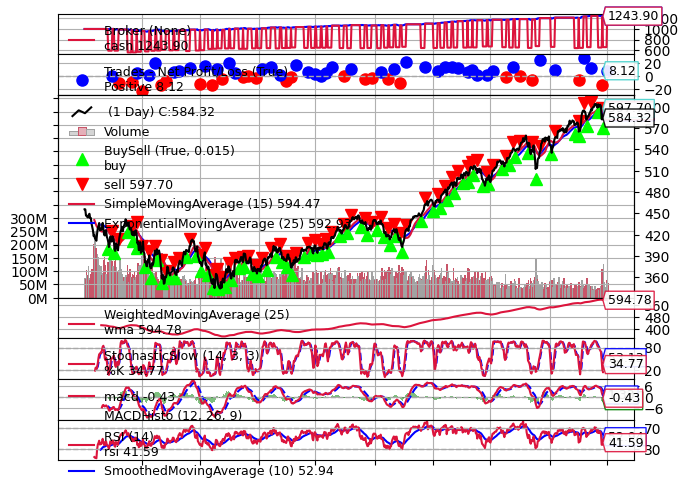

[[<Figure size 640x480 with 8 Axes>]]

In [11]:
#specify iplot=False to display the image inline :)
cerebro.plot(iplot=False, figsize=(18, 9))

#### Optimization
 We pass a set of MA period to see which one will give us the best performace!

In [12]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])


# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.optstrategy(
        TestStrategy,
        maperiod=range(10, 31))

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')

    # Create a Data Feed
    #getting data via yf API
    data = yf.download('SPY',start='2022-01-01',end='2025-01-01')
    #remove the multi-ndexing of the dataframe
    data = data.droplevel(level=1,axis=1)
    #load into backtrader the pd.dataframe
    data = bt.feeds.PandasData(dataname=data)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Run over everything
    cerebro.run(maxcpus=1)

[*********************100%***********************]  1 of 1 completed


2024-12-31, (MA Period 10) Ending Value 1000.00
2024-12-31, (MA Period 11) Ending Value 1000.00
2024-12-31, (MA Period 12) Ending Value 1000.00
2024-12-31, (MA Period 13) Ending Value 1000.00
2024-12-31, (MA Period 14) Ending Value 1000.00
2024-12-31, (MA Period 15) Ending Value 1000.00
2024-12-31, (MA Period 16) Ending Value 1000.00
2024-12-31, (MA Period 17) Ending Value 1000.00
2024-12-31, (MA Period 18) Ending Value 1000.00
2024-12-31, (MA Period 19) Ending Value 1000.00
2024-12-31, (MA Period 20) Ending Value 1000.00
2024-12-31, (MA Period 21) Ending Value 1000.00
2024-12-31, (MA Period 22) Ending Value 1000.00
2024-12-31, (MA Period 23) Ending Value 1000.00
2024-12-31, (MA Period 24) Ending Value 1000.00
2024-12-31, (MA Period 25) Ending Value 1000.00
2024-12-31, (MA Period 26) Ending Value 1000.00
2024-12-31, (MA Period 27) Ending Value 1000.00
2024-12-31, (MA Period 28) Ending Value 1000.00
2024-12-31, (MA Period 29) Ending Value 1000.00
2024-12-31, (MA Period 30) Ending Value 

### Trying a Strategy Myself :)